lien de l'étude : https://dl.acm.org/doi/pdf/10.1145/3626772.3657749

dataset yahoo : https://www.kaggle.com/datasets/limitiao/yahoor3?resource=download

dataset coat : https://www.kaggle.com/datasets/kkkongxin/dataset-coat



Validation MSE: 5.6698, MAE: 1.9217, RMSE: 2.3811, R2: -1.7820
Baseline MSE: 2.2939, MAE: 1.2978, RMSE: 1.5146, R2: -0.1220
SVD MSE: 6.0724, MAE: 2.0178, RMSE: 2.4642, R2: -1.9703


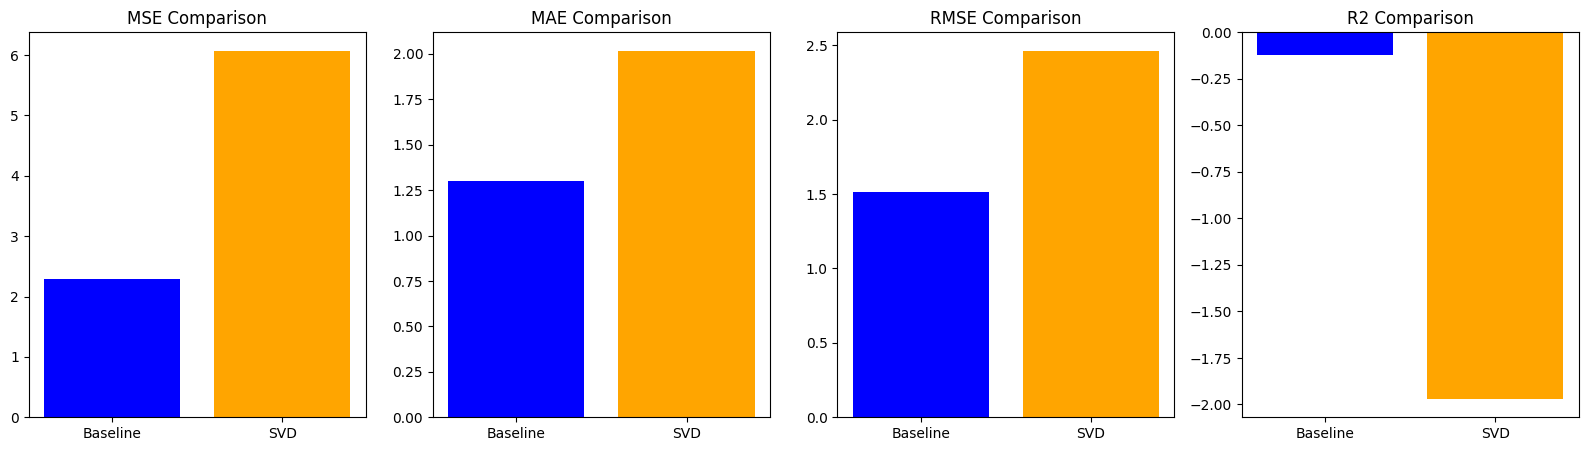

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

# ----------------------------
# STEP 1: DATA LOADING
# ----------------------------

def load_yahoo_data():
    """
    Load Yahoo! R3 dataset from predefined train, validation, and test files.
    """

    train = pd.read_csv("./yahoo_preprocessed/trainset.csv")
    valid = pd.read_csv("./yahoo_preprocessed/validset.csv")
    test = pd.read_csv("./yahoo_preprocessed/testset.csv")
    train = train[['user_id', 'item_id', 'rating']]
    valid = valid[['user_id', 'item_id', 'rating']]
    test = test[['user_id', 'item_id', 'rating']]

    train.columns = valid.columns = test.columns = ['user_id', 'item_id', 'rating']
    return train, valid, test


def load_coat_data():
    """
    Load Coat dataset from predefined train, validation, and test files.
    """
    train = pd.read_csv("./coat/trainset.csv")
    valid = pd.read_csv("./coat/validset.csv")
    test = pd.read_csv("./coat/testset.csv")
    train.columns = valid.columns = test.columns = ['user_id', 'item_id', 'rating']
    return train, valid, test


# ----------------------------
# STEP 1B: SYNTHETIC DATASET GENERATION
# ----------------------------

def generate_synthetic_data(num_users=100, num_items=50, num_ratings=500):
    """
    Generate a synthetic dataset for testing purposes.
    """
    user_ids = np.random.randint(1, num_users + 1, num_ratings)
    item_ids = np.random.randint(1, num_items + 1, num_ratings)
    ratings = np.random.randint(1, 6, num_ratings)
    data = pd.DataFrame({'user_id': user_ids, 'item_id': item_ids, 'rating': ratings})
    return data

# ----------------------------
# STEP 2: MATRIX FACTORIZATION WITH SVD
# ----------------------------

def baseline_recommender(train, test):
    """
    Baseline model predicting average item rating.
    """
    item_means = train.groupby('item_id')['rating'].mean()
    return test['item_id'].map(lambda x: item_means.get(x, 3))

def svd_recommender(train, test, k=20):
    """
    Implements Singular Value Decomposition (SVD) for recommendation.
    """
    user_means = train.groupby('user_id')['rating'].mean()
    train['rating_normalized'] = train.apply(lambda x: x['rating'] - user_means.get(x['user_id'], 3), axis=1)
    user_item_matrix = train.pivot_table(index='user_id', columns='item_id', values='rating', aggfunc='mean', fill_value=0)
    sparse_matrix = csr_matrix(user_item_matrix.values)
    U, sigma, Vt = svds(sparse_matrix, k=k)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    
    predictions = []
    num_users, num_items = predicted_ratings.shape
    
    for _, row in test.iterrows():
        user_idx = int(row['user_id']) - 1
        item_idx = int(row['item_id']) - 1
        
        if user_idx < 0 or user_idx >= num_users:
            user_idx = np.random.randint(num_users)
        if item_idx < 0 or item_idx >= num_items:
            item_idx = np.random.randint(num_items)
        
        predictions.append(predicted_ratings[user_idx, item_idx])
    
    return np.clip(predictions, 1, 5)

# ----------------------------
# STEP 3: EVALUATION
# ----------------------------

def evaluate(test, predictions):
    """
    Compute Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R2).
    """
    mse = mean_squared_error(test['rating'], predictions)
    mae = mean_absolute_error(test['rating'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test['rating'], predictions)
    return mse, mae, rmse, r2

# ----------------------------
# STEP 4: EXPERIMENTATION
# ----------------------------

def run_experiment(dataset='yahoo', use_synthetic=False):
    if use_synthetic:
        train = generate_synthetic_data()
        valid = generate_synthetic_data()
        test = generate_synthetic_data()
    elif dataset == 'coat':
        train, valid, test = load_coat_data()
    else:
        train, valid, test = load_yahoo_data()
    
    # Tune hyperparameter k using validation set
    best_k = 20  # You can implement hyperparameter tuning here
    
    # Evaluate on validation set
    svd_valid_predictions = svd_recommender(train, valid, k=best_k)
    valid_mse, valid_mae, valid_rmse, valid_r2 = evaluate(valid, svd_valid_predictions)
    print(f'Validation MSE: {valid_mse:.4f}, MAE: {valid_mae:.4f}, RMSE: {valid_rmse:.4f}, R2: {valid_r2:.4f}')
    
    # Final evaluation on test set
    baseline_predictions = baseline_recommender(train, test)
    baseline_mse, baseline_mae, baseline_rmse, baseline_r2 = evaluate(test, baseline_predictions)
    
    svd_predictions = svd_recommender(train, test, k=best_k)
    svd_mse, svd_mae, svd_rmse, svd_r2 = evaluate(test, svd_predictions)
    
    print(f'Baseline MSE: {baseline_mse:.4f}, MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, R2: {baseline_r2:.4f}')
    print(f'SVD MSE: {svd_mse:.4f}, MAE: {svd_mae:.4f}, RMSE: {svd_rmse:.4f}, R2: {svd_r2:.4f}')
    
    labels = ['Baseline', 'SVD']
    mse_values = [baseline_mse, svd_mse]
    mae_values = [baseline_mae, svd_mae]
    rmse_values = [baseline_rmse, svd_rmse]
    r2_values = [baseline_r2, svd_r2]
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.bar(labels, mse_values, color=['blue', 'orange'])
    plt.title("MSE Comparison")
    
    plt.subplot(1, 4, 2)
    plt.bar(labels, mae_values, color=['blue', 'orange'])
    plt.title("MAE Comparison")
    
    plt.subplot(1, 4, 3)
    plt.bar(labels, rmse_values, color=['blue', 'orange'])
    plt.title("RMSE Comparison")
    
    plt.subplot(1, 4, 4)
    plt.bar(labels, r2_values, color=['blue', 'orange'])
    plt.title("R2 Comparison")
    
    plt.show()

if __name__ == "__main__":
    run_experiment(dataset='', use_synthetic=True)



In [16]:
%pip install torch


import numpy as np
import pandas as pd
import torch

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from implicit.als import AlternatingLeastSquares


# ----------------------------
# STEP 1: DATA LOADING
# ----------------------------

def load_yahoo_data():
    """
    Load Yahoo! R3 dataset from predefined train, validation, and test files.
    """

    train = pd.read_csv("./yahoo_preprocessed/trainset.csv")
    valid = pd.read_csv("./yahoo_preprocessed/validset.csv")
    test = pd.read_csv("./yahoo_preprocessed/testset.csv")
    train = train[['user_id', 'item_id', 'rating']]
    valid = valid[['user_id', 'item_id', 'rating']]
    test = test[['user_id', 'item_id', 'rating']]

    train.columns = valid.columns = test.columns = ['user_id', 'item_id', 'rating']
    return train, valid, test


def load_coat_data():
    """
    Load Coat dataset from predefined train, validation, and test files.
    """
    train = pd.read_csv("./coat/trainset.csv")
    valid = pd.read_csv("./coat/validset.csv")
    test = pd.read_csv("./coat/testset.csv")
    train.columns = valid.columns = test.columns = ['user_id', 'item_id', 'rating']
    return train, valid, test


# ----------------------------
# STEP 1B: SYNTHETIC DATASET GENERATION
# ----------------------------


def generate_synthetic_data(num_users=100, num_items=50, num_ratings=500):
    user_ids = np.random.randint(1, num_users + 1, num_ratings)
    item_ids = np.random.randint(1, num_items + 1, num_ratings)
    ratings = np.random.randint(1, 6, num_ratings)
    return pd.DataFrame({'user_id': user_ids, 'item_id': item_ids, 'rating': ratings})

# ----------------------------
# STEP 2: PROPENSITY SCORE COMPUTATION
# ----------------------------

def compute_propensities(df):
    item_popularity = df['item_id'].value_counts(normalize=True)
    rating_distribution = df['rating'].value_counts(normalize=True)
    df['popularity_propensity'] = df['item_id'].map(lambda x: item_popularity.get(x, 0.01))
    df['positivity_propensity'] = df['rating'].map(lambda x: rating_distribution.get(x, 0.01))
    df['multifactorial_propensity'] = df['popularity_propensity'] * df['positivity_propensity']
    df['ips_weight'] = 1 / (df['multifactorial_propensity'] + 1e-6)
    df['weighted_rating'] = df['rating'] * df['ips_weight']
    return df

# ----------------------------
# STEP 3: MATRIX FACTORIZATION WITH SVD & ALS
# ----------------------------

def baseline_recommender(train, test):
    item_means = train.groupby('item_id')['rating'].mean()
    return test['item_id'].map(lambda x: item_means.get(x, 3))

def svd_recommender(train, test, k=20, debias=False):
    column = 'weighted_rating' if debias else 'rating'
    user_means = train.groupby('user_id')[column].mean()
    train['rating_normalized'] = train.apply(lambda x: x[column] - user_means.get(x['user_id'], 3), axis=1)
    user_item_matrix = train.pivot_table(index='user_id', columns='item_id', values=column, aggfunc='mean', fill_value=0)
    sparse_matrix = csr_matrix(user_item_matrix)
    U, sigma, Vt = svds(sparse_matrix, k=k)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    
    predictions = []
    num_users, num_items = predicted_ratings.shape
    
    for _, row in test.iterrows():
        user_idx = min(max(int(row['user_id']) - 1, 0), num_users - 1)
        item_idx = min(max(int(row['item_id']) - 1, 0), num_items - 1)
        predictions.append(predicted_ratings[user_idx, item_idx])
    
    return np.clip(predictions, 1, 5)

def als_recommender(train, test, factors=20, debias=False):
    column = 'weighted_rating' if debias else 'rating'
    user_item_matrix = csr_matrix(train.pivot_table(index='user_id', columns='item_id', values=column, aggfunc='mean', fill_value=0))
    model = AlternatingLeastSquares(factors=factors, iterations=20)
    model.fit(user_item_matrix)
    
    predictions = []
    num_users, num_items = user_item_matrix.shape
    
    for _, row in test.iterrows():
        user_idx = min(max(int(row['user_id']) - 1, 0), num_users - 1)
        item_idx = min(max(int(row['item_id']) - 1, 0), num_items - 1)
        predictions.append(model.user_factors[user_idx] @ model.item_factors[item_idx].T)
    
    return np.clip(predictions, 1, 5)


# Neural Collaborative Filtering (NCF)
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=20):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, 1)

    def forward(self, user_ids, item_ids):
        user_emb = self.user_embedding(user_ids)
        item_emb = self.item_embedding(item_ids)
        x = torch.cat([user_emb, item_emb], dim=-1)
        return self.fc(x).squeeze()



# ----------------------------
# STEP 4: EVALUATION
# ----------------------------

def evaluate(test, predictions):
    mse = mean_squared_error(test['rating'], predictions)
    mae = mean_absolute_error(test['rating'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test['rating'], predictions)
    return mse, mae, rmse, r2

# ----------------------------
# STEP 6: EXPERIMENTATION
# ----------------------------

def run_experiment(dataset='yahoo', use_synthetic=False):
    if use_synthetic:
        train = generate_synthetic_data()
        valid = generate_synthetic_data()
        test = generate_synthetic_data()
    elif dataset == 'yahoo':
        train, valid, test = load_yahoo_data()
    elif dataset == 'coat':
        train, valid, test = load_coat_data()
    
    train = compute_propensities(train)
    valid = compute_propensities(valid)
    test = compute_propensities(test)
    
    best_k = 20
    
    svd_predictions = svd_recommender(train, test, k=best_k, debias=False)
    svd_debias_predictions = svd_recommender(train, test, k=best_k, debias=True)
    als_predictions = als_recommender(train, test, factors=best_k, debias=False)
    als_debias_predictions = als_recommender(train, test, factors=best_k, debias=True)
    
    print("Without Bias Correction:")
    print(evaluate(test, svd_predictions))
    print(evaluate(test, als_predictions))
    print("With Bias Correction:")
    print(evaluate(test, svd_debias_predictions))
    print(evaluate(test, als_debias_predictions))

if __name__ == "__main__":
    run_experiment(dataset='yahoo', use_synthetic=False)


Defaulting to user installation because normal site-packages is not writeable
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 16.2 MB/s eta 0:00:00a 0:00:01
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached filelock-3.17.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Without Bias Correction:
(1.7946417055866035, 0.8217243790126296, np.float64(1.339642379736698), -0.6062386757104727)
(1.7871989011764526, 0.8185521364212036, np.float64(1.3368615863942133), -0.5995773077011108)
With Bias Correction:
(9.016225495913345, 2.6321134838265094, np.float64(3.002703031588929), -7.069694388233968)
(1.7786896228790283, 0.818942129611969, np.float64(1.3336752314109415), -0.5919613838195801)


In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from implicit.als import AlternatingLeastSquares


def load_yahoo_data():
    """
    Load Yahoo! R3 dataset from predefined train, validation, and test files.
    """

    train = pd.read_csv("./yahoo_preprocessed/trainset.csv")
    valid = pd.read_csv("./yahoo_preprocessed/validset.csv")
    test = pd.read_csv("./yahoo_preprocessed/testset.csv")
    train = train[['user_id', 'item_id', 'rating']]
    valid = valid[['user_id', 'item_id', 'rating']]
    test = test[['user_id', 'item_id', 'rating']]

    train.columns = valid.columns = test.columns = ['user_id', 'item_id', 'rating']
    return train, valid, test


def load_coat_data():
    """
    Load Coat dataset from predefined train, validation, and test files.
    """
    train = pd.read_csv("./coat/trainset.csv")
    valid = pd.read_csv("./coat/validset.csv")
    test = pd.read_csv("./coat/testset.csv")
    train.columns = valid.columns = test.columns = ['user_id', 'item_id', 'rating']
    return train, valid, test


# ----------------------------
# STEP 1B: SYNTHETIC DATASET GENERATION
# ----------------------------

def generate_synthetic_data(num_users=100, num_items=50, num_ratings=500):
    user_ids = np.random.randint(1, num_users + 1, num_ratings)
    item_ids = np.random.randint(1, num_items + 1, num_ratings)
    ratings = np.random.randint(1, 6, num_ratings)
    return pd.DataFrame({'user_id': user_ids, 'item_id': item_ids, 'rating': ratings})

# ----------------------------
# STEP 2: PROPENSITY SCORE COMPUTATION
# ----------------------------

def compute_propensities(df):
    item_popularity = df['item_id'].value_counts(normalize=True)
    rating_distribution = df['rating'].value_counts(normalize=True)
    df['popularity_propensity'] = df['item_id'].map(lambda x: item_popularity.get(x, 0.01))
    df['positivity_propensity'] = df['rating'].map(lambda x: rating_distribution.get(x, 0.01))
    df['multifactorial_propensity'] = df['popularity_propensity'] * df['positivity_propensity']
    df['ips_weight'] = 1 / (df['multifactorial_propensity'] + 1e-6)
    df['weighted_rating'] = df['rating'] * df['ips_weight']
    return df

# ----------------------------
# STEP 3: MATRIX FACTORIZATION WITH SVD & ALS
# ----------------------------

def baseline_recommender(train, test):
    item_means = train.groupby('item_id')['rating'].mean()
    return test['item_id'].map(lambda x: item_means.get(x, 3))

# Neural Collaborative Filtering (NCF)
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=20):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, 1)

    def forward(self, user_ids, item_ids):
        user_emb = self.user_embedding(user_ids)
        item_emb = self.item_embedding(item_ids)
        x = torch.cat([user_emb, item_emb], dim=-1)
        return self.fc(x).squeeze()


def train_ncf(train, valid, num_epochs=10, embedding_dim=20):
    num_users = int(train['user_id'].max()) + 1
    num_items = int(train['item_id'].max()) + 1
    model = NCF(num_users, num_items, embedding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_users = torch.tensor(train['user_id'].values, dtype=torch.long)
    train_items = torch.tensor(train['item_id'].values, dtype=torch.long)
    train_ratings = torch.tensor(train['rating'].values, dtype=torch.float)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(train_users, train_items)
        loss = criterion(predictions, train_ratings)
        loss.backward()
        optimizer.step()
        
    return model


def evaluate_ncf(model, test):
    model.eval()
    test_users = torch.tensor(test['user_id'].values, dtype=torch.long)
    test_items = torch.tensor(test['item_id'].values, dtype=torch.long)
    with torch.no_grad():
        predictions = model(test_users, test_items).numpy()
    return predictions

# ----------------------------
# STEP 4: EVALUATION
# ----------------------------

def evaluate(test, predictions):
    mse = mean_squared_error(test['rating'], predictions)
    mae = mean_absolute_error(test['rating'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test['rating'], predictions)
    return mse, mae, rmse, r2

# ----------------------------
# STEP 6: EXPERIMENTATION
# ----------------------------

def run_experiment(dataset='yahoo', use_synthetic=False):
    if use_synthetic:
        train = generate_synthetic_data()
        valid = generate_synthetic_data()
        test = generate_synthetic_data()
    elif dataset == 'yahoo':
        train, valid, test = load_yahoo_data()
    elif dataset == 'coat':
        train, valid, test = load_coat_data()
    
    train = compute_propensities(train)
    valid = compute_propensities(valid)
    test = compute_propensities(test)
    
    best_k = 20
    
    ncf_model = train_ncf(train, valid)
    ncf_predictions = evaluate_ncf(ncf_model, test)
    
    print("Neural Collaborative Filtering (NCF):")
    print(evaluate(test, ncf_predictions))
    
if __name__ == "__main__":
    run_experiment(dataset='yahoo', use_synthetic=False)


Neural Collaborative Filtering (NCF):
(4.432999610900879, 1.7522687911987305, np.float64(2.105468976475521), -2.9676198959350586)
